<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 4 / SPRINT 1 / NOTE 2*

---

# Vectorization of Texts

* 텍스트 문서를 벡터로 표현해 봅시다
* 유사도를 이용해 문서를 검색해 봅시다
* 문서를 벡터로 만들기 위해 단어 임베딩을 사용해 봅시다

### Warm up


#### Vectorization of Texts (텍스트 벡터화)

컴퓨터는 자연어를 있는 그대로 이해할 수 없습니다. 그래서 자연어를 컴퓨터가 사용할 수 있는 형태로 가공해야 합니다. 이전 강의에서는 정제된 토큰의 수를 기반으로 분석을 진행하였습니다. 오늘은 이 개념을 좀 더 확장시켜 **Bag-of-Words(BoW), Term Frequency-Inverse Document Frequency ([TF-IDF](https://youtu.be/meEchvkdB1U))** 같은 텍스트를 벡터화 하는 방법과 **단어 임베딩(Word embedding) 모델**에 대해 다루어 보겠습니다. 다음 수업에 진행할 검색, 시각화, 분류 작업에 벡터 표현법을 활용할 것입니다.

- TF - 문서에서 단어가 많이 등장하는 지를 수치화한 중요도 스코어(score)
- $\space$ ex) "A new car, used car, car reivew" <br> - TF score :  A($1 \over 7$), new($1 \over 7$), car($3 \over 7$), used($1 \over 7$), reivew($1 \over 7$) 
- IDF - $log {(총 \space 문장 \space 개수) \over {(단어가 \space 출현한 \space 문장의 \space 개수)}}$
-  $\space$ ex) 'A'가 모든 문장에서 등장 IDF = log(N/N) = 0
- TF-IDF score = TF * IDF = (1/7) * 0 = 0


머신러닝 모델에서 사용하기 위해 텍스트 데이터를 벡터화하는 것은 컴퓨터가 사용할 수 있는 수치정보()로 변환하는것으로 생각할 수 있습니다.

Bag-of-Words(BoW) 모델은 문장이나 문서들에서 문법, 단어 순서 등의 개념을 제거하여 단순히 **단어들의 빈도**만 고려하는 모델입니다.

BoW는 문서를 토큰화한 후 토큰의 빈도를 기반으로 벡터화 합니다. 데이터프레임 형태로 보자면 행은 각 문서가 되고 열은 중복되지 않는 각 단어가 됩니다. 열에는 단순히 각 단어가 문서에 얼마나 존재하는지를 카운트한 값을 넣거나(*CountVectorizer* 사용) TF-IDF 값이 오게 할 수 있습니다(*TfidfVectorizer 사용).

벡터 표현은 파이썬에서는 `sklearn`, `spacy`패키지를 사용해 구현할 수 있습니다.


#### Dataset

이번 세션에서는 BBC에서 제공하는 데이터셋을 사용하여 텍스트를 다뤄볼 예정입니다. BBC 웹사이트를 방문하는 고객이 방금 읽은 뉴스(문서)를 기반으로 비슷한 다른 문서를 적절하게 추천하게 만들 수 있으면 좋겠죠. 그런 작업을 한번 시작해 봅니다. 

* 아래 링크에서 파일을 다운로드 받아 노트 폴더에서 압축을 해제합니다. <br> data folder가 생성되고 001.txt ~ 401.txt 파일이 있는지 확인합니다.
* colab 유저들은 업로드 코드를 이용하여 업로드 후 unzip하여 파일을 풀면 사용할 수 있습니다.

[bbc_fulltext.zip](https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/bbc_fulltext/bbc_fulltext.zip)


#### 레퍼런스
[BBC News Tech]('https://www.bbc.com/news/technology')
, D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006. [논문링크](http://mlg.ucd.ie/datasets/bbc.html)

**(예제에서는 tech 관련 문서만 사용합니다)** <br>
파일을 논문링크에서 직접 받을 수 있으나 몇가지 조치를 해야 합니다. 링크에서, <br> Dataset: BBC -> >> Download raw text files -> 압축해제(bbc-fulltext.zip) <br> > tech 폴더의 이름을 변경 한 뒤 "txt 파일(001.txt ~ 401.txt) 확인" > 원하는 위치로 이동 후 사용가능.



---

## 텍스트 문서를 벡터로 표현해 봅시다

BoW를 사용해 Document Term Matrices(DTM, 문서-단어행렬)을 만들어 보겠습니다. 각 행은 문서를 나타내고 각 열은 단어를 나타냅니다.
- 각 셀의 값은 여러가지 방법으로 표현될 수 있는데
    - 단어의 출현 빈도를 나타내거나,
    - 단순히 단어의 존재 유무(binary)를 표현할 수 있고,
    - TF-IDF 값으로 나타낼 수 있습니다.

In [1]:
# 모듈에서 사용할 라이브러리와 spacy 모델을 불러옵니다.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import spacy
nlp = spacy.load("en_core_web_sm")

**Spacy로 텍스트에서 토큰을 추출해 보겠습니다.**

In [2]:
text = "In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. tf–idf is one of the most popular term-weighting schemes today. A survey conducted in 2015 showed that 83% of text-based recommender systems in digital libraries use tf–idf."

In [3]:
doc = nlp(text)

print([token.lemma_ for token in doc if (token.is_stop != True) and (token.is_punct != True)])

['information', 'retrieval', 'tf', 'idf', 'TFIDF', 'short', 'term', 'frequency', 'inverse', 'document', 'frequency', 'numerical', 'statistic', 'intend', 'reflect', 'important', 'word', 'document', 'collection', 'corpus', 'weight', 'factor', 'search', 'information', 'retrieval', 'text', 'mining', 'user', 'modeling', 'tf', 'idf', 'value', 'increase', 'proportionally', 'number', 'time', 'word', 'appear', 'document', 'offset', 'number', 'document', 'corpus', 'contain', 'word', 'help', 'adjust', 'fact', 'word', 'appear', 'frequently', 'general', 'tf', 'idf', 'popular', 'term', 'weight', 'scheme', 'today', 'survey', 'conduct', '2015', 'show', '83', 'text', 'base', 'recommender', 'system', 'digital', 'library', 'use', 'tf', 'idf']


In [4]:
import os 

# BBC 데이터를 불러오기 위한 함수입니다.

def gather_data(filefolder):
    """ 폴더 내 텍스트 파일을 각각 리스트 요소에 저장하는 함수
    Args:
        filefolder (str): .txt 파일이 존재하는 경로
    Returns:
        문서를 요소로하는 리스트
    """
    
    data = []
    
    files = os.listdir(filefolder)
    
    for article in files: 
        path = os.path.join(filefolder, article)

        # txt로 끝나는 파일만 읽습니다
        if  path[-3:] == 'txt':
            # rb:Read the file in Binary mode
            with open(path, 'rb') as f:
                data.append(f.read())
    
    return data

In [14]:
# for Colab User
# Upload files
from google.colab import files
uploaded = files.upload()
!unzip "bbc_fulltext.zip" # 업로드 이름이 다르다면 수정해서 사용하세요.

KeyboardInterrupt: ignored

In [19]:
# 폴더가 제대로 생성되었는 지 확인합니다. 
!ls

'bbc_fulltext (1).zip'	 data   sample_data


bbc tech 관련 문서들을 불러옵니다.

In [12]:
data = gather_data('./data')

In [13]:
data[0]

b'Joke e-mail virus tricks users\n\nA virus that disguises itself as a joke is spreading rapidly across the net.\n\nAnti-virus firms are issuing high-level warnings about the new version of the Bagle e-mail program that seems to be catching a lot of people out. The Windows virus grabs e-mail addresses from Microsoft Outlook and uses its own mail sending software to spread itself to new victims. When it infects a machine, the Bagle variant turns off security measures that usually protect PCs.\n\nThe new variant is called Bagle.AT, Bagle.BB and Bagle.AU and the attachment bearing the virus code is labelled as either "joke" or "price".\n\nThe body of the virus usually contains nothing but a smiley or emoticon. The virus can strike computers running Windows 95, 98, ME, NT, 2000 and XP. Users will be infected if they open the attachment that travels with the e-mail. As well as plundering Microsoft Outlook for e-mail addresses to send itself to, Bagle.AT also tries to turn off the firewall a

In [20]:
import seaborn as sns
# plot 스타일과 폰트 크기를 설정합니다.
sns.set(style='whitegrid', font_scale=1.15)

# 문서별 단어의 수 분포도 그리는 함수
def plot_text_length_dist(text_list):

    # 문장이 요소인 리스트를 받아 각 문서의 단어 수를 가진 리스트를 만듭니다
    num_words = [len(doc.split()) for doc in text_list]
    
    sns.displot(num_words)
    plt.title('# of words per documents')
    plt.xlabel('Number of words')
    plt.ylabel('Number of documents')
    plt.show()       

대략 500 단어 정도로 표현된 문서가 가장 많이 보입니다.

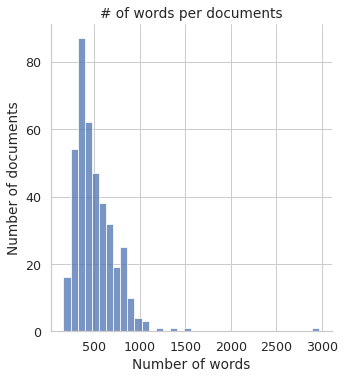

In [21]:
plot_text_length_dist(data)

### CountVectorizer
: 단어들의 출현 빈도로 여러개의 문서를 벡터화하는 함수 <br>
: 모든 문자를 소문자로 전환하여 계산함

In [86]:
from sklearn.feature_extraction.text import CountVectorizer

# wiki 문장들을 리스트에 나누어 입력해봅니다. 
text = ["In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus."
,"It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling."
,"The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general."
,"tf–idf is one of the most popular term-weighting schemes today."
,"A survey conducted in 2015 showed that 83% of text-based recommender systems in digital libraries use tf–idf."]

# CountVectorizer 생성
vect = CountVectorizer()

# text를 기반으로 어휘 사전을 생성
vect.fit(text) 
# vect.fit(data[:5])

# text를 DTM(document-term matrix)으로 변환(transform)
dtm = vect.transform(text)
# dtm = vect.transform(data[:5])

vocabulary(모든 토큰)와 맵핑된 인덱스 정보를 확인할 수 있습니다

In [87]:
vect.vocabulary_

{'2015': 0,
 '83': 1,
 'adjust': 2,
 'and': 3,
 'appear': 4,
 'appears': 5,
 'as': 6,
 'based': 7,
 'by': 8,
 'collection': 9,
 'conducted': 10,
 'contain': 11,
 'corpus': 12,
 'digital': 13,
 'document': 14,
 'documents': 15,
 'fact': 16,
 'factor': 17,
 'for': 18,
 'frequency': 19,
 'frequently': 20,
 'general': 21,
 'helps': 22,
 'how': 23,
 'idf': 24,
 'important': 25,
 'in': 26,
 'increases': 27,
 'information': 28,
 'intended': 29,
 'inverse': 30,
 'is': 31,
 'it': 32,
 'libraries': 33,
 'mining': 34,
 'modeling': 35,
 'more': 36,
 'most': 37,
 'number': 38,
 'numerical': 39,
 'of': 40,
 'offset': 41,
 'often': 42,
 'one': 43,
 'or': 44,
 'popular': 45,
 'proportionally': 46,
 'recommender': 47,
 'reflect': 48,
 'retrieval': 49,
 'schemes': 50,
 'searches': 51,
 'short': 52,
 'showed': 53,
 'some': 54,
 'statistic': 55,
 'survey': 56,
 'systems': 57,
 'term': 58,
 'text': 59,
 'tf': 60,
 'tfidf': 61,
 'that': 62,
 'the': 63,
 'times': 64,
 'to': 65,
 'today': 66,
 'use': 67,
 'us

In [88]:
dtm.shape

(5, 75)

추출된 토큰을 나열해 봅니다.

In [89]:
print(vect.get_feature_names())

['2015', '83', 'adjust', 'and', 'appear', 'appears', 'as', 'based', 'by', 'collection', 'conducted', 'contain', 'corpus', 'digital', 'document', 'documents', 'fact', 'factor', 'for', 'frequency', 'frequently', 'general', 'helps', 'how', 'idf', 'important', 'in', 'increases', 'information', 'intended', 'inverse', 'is', 'it', 'libraries', 'mining', 'modeling', 'more', 'most', 'number', 'numerical', 'of', 'offset', 'often', 'one', 'or', 'popular', 'proportionally', 'recommender', 'reflect', 'retrieval', 'schemes', 'searches', 'short', 'showed', 'some', 'statistic', 'survey', 'systems', 'term', 'text', 'tf', 'tfidf', 'that', 'the', 'times', 'to', 'today', 'use', 'used', 'user', 'value', 'weighting', 'which', 'word', 'words']


In [90]:
data[4]

b'Mobiles rack up 20 years of use\n\nMobile phones in the UK are celebrating their 20th anniversary this weekend.\n\nBritain\'s first mobile phone call was made across the Vodafone network on 1 January 1985 by veteran comedian Ernie Wise. In the 20 years since that day, mobile phones have become an integral part of modern life and now almost 90% of Britons own a handset. Mobiles have become so popular that many people use their handset as their only phone and rarely use a landline.\n\nThe first ever call over a portable phone was made in 1973 in New York but it took 10 years for the first commercial mobile service to be launched. The UK was not far behind the rest of the world in setting up networks in 1985 that let people make calls while they walked. The first call was made from St Katherine\'s dock to Vodafone\'s head office in Newbury which at the time was over a curry house. For the first nine days of 1985 Vodafone was the only firm with a mobile network in the UK. Then on 10 Janu

dtm의 타입을 보면 compressed sparse Row matrix임을 알 수 있습니다. csr: Compressed Sparse Row matrix, sparse matrix 형태에서 0을 표현하지 않습니다.

In [91]:
type(dtm)

scipy.sparse.csr.csr_matrix

In [93]:
# (row, column)  count
print(dtm)

  (0, 9)	1
  (0, 12)	1
  (0, 14)	2
  (0, 18)	1
  (0, 19)	2
  (0, 23)	1
  (0, 24)	1
  (0, 25)	1
  (0, 26)	2
  (0, 28)	1
  (0, 29)	1
  (0, 30)	1
  (0, 31)	3
  (0, 39)	1
  (0, 44)	2
  (0, 48)	1
  (0, 49)	1
  (0, 52)	1
  (0, 55)	1
  (0, 58)	1
  (0, 60)	1
  (0, 61)	1
  (0, 62)	1
  (0, 65)	2
  (0, 73)	1
  :	:
  (3, 43)	1
  (3, 45)	1
  (3, 50)	1
  (3, 58)	1
  (3, 60)	1
  (3, 63)	1
  (3, 66)	1
  (3, 71)	1
  (4, 0)	1
  (4, 1)	1
  (4, 7)	1
  (4, 10)	1
  (4, 13)	1
  (4, 24)	1
  (4, 26)	2
  (4, 33)	1
  (4, 40)	1
  (4, 47)	1
  (4, 53)	1
  (4, 56)	1
  (4, 57)	1
  (4, 59)	1
  (4, 60)	1
  (4, 62)	1
  (4, 67)	1


0을 표현한 형태로 만들면 .todense를 사용할 수 있고, 이런경우 numpy.matrix형태가 됩니다. 

In [94]:
# Return a dense matrix representation
# dtm.todense()
print(type(dtm))
print(type(dtm.todense()))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.matrix'>


데이터프레임 형태로 결과를 보고 싶다면

In [95]:
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
print(type(dtm))
dtm

<class 'pandas.core.frame.DataFrame'>


,2015,83,adjust,and,appear,appears,as,based,by,collection,conducted,contain,corpus,digital,document,documents,fact,factor,for,frequency,frequently,general,helps,how,idf,important,in,increases,information,intended,inverse,is,it,libraries,mining,modeling,more,most,number,numerical,of,offset,often,one,or,popular,proportionally,recommender,reflect,retrieval,schemes,searches,short,showed,some,statistic,survey,systems,term,text,tf,tfidf,that,the,times,to,today,use,used,user,value,weighting,which,word,words
0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,2,0,0,0,1,2,0,0,0,1,1,1,2,0,1,1,1,3,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,1,1,0,0,2,0,0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0
2,0,0,1,1,1,1,0,0,1,0,0,1,1,0,1,1,1,0,1,0,1,1,1,0,1,0,3,1,0,0,0,1,0,0,0,0,1,0,2,0,2,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,2,7,1,2,0,0,0,0,1,0,1,2,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0
4,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0


세번째 문장과, dtm을 비교해 보겠습니다. 

In [97]:
text[2]

'The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.'

**CountVectorizer를 BBC data에 적용해 봅시다**

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

## stop_words = 'english' 영어에 해당하는 불용어 처리를 합니다.
## max_features=n, 빈도 순서대로 top n 단어만 사용합니다.
vect = CountVectorizer(stop_words='english'
                       , max_features=10000)
# fit & transform
dtm = vect.fit_transform(data)

dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm.shape

(401, 10000)

In [38]:
dtm.head()

,00,000,000s,0051,007,01,028,04m,05,0530,056,0630,080,0800,0870,10,100,1000,100m,100s,101,102,104,106,106cm,1080,10cm,10m,10s,10th,10x7in,11,110,115,117,11b,11m,12,120,120bn,...,yeob,yepp,yes,yesterday,yeun,yh,yle,yoda,yoga,yonca,yoran,york,yorker,young,younger,youngsters,youth,yuppy,yusuf,zafi,zander,zar,zdnet,zealous,zed,zelda,zen,zenith,zens,zero,zhang,zip,zodiac,zombie,zombies,zone,zonealarm,zones,zoom,zooms
0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### TfidfVectorizer

#### Term Frequency - Inverse Document Frequency (TF-IDF, 단어빈도-역문서빈도)
- [TF-IDF 참고](https://mungingdata.wordpress.com/2017/11/25/episode-1-using-tf-idf-to-identify-the-signal-from-the-noise/)

*t=단어, d=문서, n=총 문서수*

TF-IDF Score <br> $ = \large tf(t,d) \times idf(t)$
<br></br>

TF(Term Frequency, 단어의 빈도), <br> **특정 문서 d에서 특정 단어 t가 쓰인 빈도**:

$\large tf(t,d) = \frac{Term\; t\; frequency\; in\; document}{Total\; words\; in\; document}$
<br></br>

DF(Document Frequency, 문서의 빈도),<br>  **특정 단어 t가 나타난 문서의 갯수**:

$\large df(t) = \small {documents\; with\; term\; t}$
<br></br>

IDF : log(n/(DF 역수(inverse)))

$\large idf(t) = log(\frac{n}{1+df(t)})$
<br></br>

TF-IDF 를 사용하는 이유는 문서를 구분하는데 어떤 단어가 중요한지(**unique**) 찾는 것 입니다.

수식을 살펴보면, 
<br> 여러 문서에서 많이 등장하는 단어일 수록 중요도가 낮다고 판단하며(IDF), <br> 특정 문서에서만 자주 등장하는 단어는 중요도가 높다고 판단합니다(TF).

TF-IDF를 통한 자연어 처리는 간단하고 빠르게 구현할 수 있으므로 좋은 Baseline으로 사용할 수 있습니다.

#### TF-IDF(Tfidf) vectorizer vs Count vectorizer
TF-IDF vectorizer를 생성하고 dtm을 만들어 보겠습니다.

In [98]:
# TF-IDF vectorizer. 테이블을 작게 만들기 위해 max_features=15로 제한하였습니다.
tfidf = TfidfVectorizer(stop_words='english', max_features=15)

# Fit 후 dtm을 만듭니다.(문서, 단어마다 tf-idf 값을 계산합니다)
dtm = tfidf.fit_transform(text)

dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())
dtm

,corpus,document,frequency,idf,information,number,recommender,reflect,retrieval,searches,term,text,tf,weighting,word
0,0.237982,0.475965,0.589946,0.166183,0.237982,0.000000,0.000000,0.294973,0.237982,0.000000,0.237982,0.000000,0.166183,0.000000,0.237982
1,0.000000,0.000000,0.000000,0.000000,0.425001,0.000000,0.000000,0.000000,0.425001,0.526778,0.000000,0.425001,0.000000,0.425001,0.000000
2,0.276074,0.276074,0.000000,0.192782,0.000000,0.684374,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.192782,0.000000,0.552149
3,0.000000,0.000000,0.000000,0.404837,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.579748,0.000000,0.404837,0.579748,0.000000
4,0.000000,0.000000,0.000000,0.372642,0.000000,0.000000,0.661438,0.000000,0.000000,0.000000,0.000000,0.533644,0.372642,0.000000,0.000000


같은 파라미터로 CountVectorizer를 사용해 tfidf 결과와 비교해 보겠습니다.

In [41]:
vect = CountVectorizer(stop_words='english', max_features=15)
dtm = vect.fit_transform(text)
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm

,corpus,document,frequency,idf,information,number,recommender,reflect,retrieval,searches,term,text,tf,weighting,word
0,1,2,2,1,1,0,0,1,1,0,1,0,1,0,1
1,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0
2,1,1,0,1,0,2,0,0,0,0,0,0,1,0,2
3,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0
4,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0


#### BBC 데이터에 tfidf vectorizer를 적용해 보겠습니다.

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
dtm = tfidf.fit_transform(data)
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

dtm.head()

,000,10,100,101,104,10m,11,12,120,13,130,14,149,15,150,16,167,17,17m,18,19,1980s,1982,1983,1985,1990s,1993,1994,1995,1bn,1m,20,200,2000,2001,2002,2003,2004,2005,2006,...,worry,worrying,worse,worst,worth,worthwhile,wouldn,wow,wright,wristwatch,write,writer,writers,writing,written,wrong,wrongful,wrote,wsis,x1,xbox,xenon,xp,xxx,yahoo,yang,year,years,yen,yes,yoda,yoran,york,young,younger,youngsters,youth,zafi,zen,zombies
0,0.026072,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.051915,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.102341,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.066212,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.034386,0.079190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.087326,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.027346,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.028192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.028940,0.066646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045824,0.0,0.0,0.0,0.073493,0.241386,0.0,0.071006,0.067081,0.0,0.0,0.0,0.122338,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.123824,0.0,0.0,0.0,0.0,0.05528,0.058505,0.0,0.0,0.0,0.0,0.0,0.0


#### 이번에는 조금 더 파라미터를 튜닝하고, spacy tokenizer 를 사용해서 벡터화를 진행해 보겠습니다.

In [100]:
# spacy tokenizer 함수
def tokenize(document):
    
    doc = nlp(document)
    # punctuations: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True) and (token.is_alpha == True)]

파라미터 튜닝을 더 해보겠습니다. 여러 파라미터들을 변경해 가며 결과를 비교해 보겠습니다.

In [101]:
# ngram_range = (min_n, max_n), min_n 개~ max_n 개를 갖는 n-gram(n개의 연속적인 토큰)을 토큰으로 사용합니다.
# min_df = n, 최소 n개의 문서에 나타나는 토큰만 사용합니다
# max_df = .7, 70% 이상 문서에 나타나는 토큰은 제거합니다
tfidf = TfidfVectorizer(stop_words='english'
                        ,tokenizer=tokenize
                        ,ngram_range=(1,2)
                        ,max_df=.7
                        ,min_df=3
#                         ,max_features = 4000
                       )

dtm = tfidf.fit_transform(data)
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())
dtm.head()

,-PRON-,abandon,ability,ability record,able,able access,able choose,able control,able handle,able offer,able play,able store,able thing,able use,able watch,absolutely,absorb,abuse,academic,academy,accept,acceptable,acceptance,access,access available,access datum,access device,access e,access grow,access home,access information,access internet,access medium,access mobile,access net,access point,access service,accessible,accident,acclaim,...,year launch,year microsoft,year million,year motorola,year new,year number,year old,year people,year portable,year predict,year real,year release,year report,year say,year service,year think,year time,year uk,year use,year year,yen,yepp,yes,york,york base,york state,york times,young,young americans,young people,young user,youngster,youth,zelda,zen,zen micro,zombie,zombie bot,zone,zoom
0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068952,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.024268,0.0,0.017571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069914,0.0,0.0,0.0,0.0,0.052588,0.0,0.0,0.0,0.049556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
dtm.shape

(401, 7604)

## 유사도를 이용해 문서를 검색해 봅시다

네이버, 구글과 같은 검색엔진의 원리는 무엇입니까? 
<br> 검색어를 인터넷에 존재하는 여러 문서들과 단순히 같은지만 비교 하는것은 아닙니다. 쿼리와 문서들을 매칭(matching) 하는 방법은 여러가지가 있습니다. 그중 가장 클래식한 방법인 "유사도 측정 방법"을 시도해 봅니다. 
<br> 이를 위해 n-차원 거리를 사용하는 방법을 살펴보겠습니다.

### 코사인 유사도(Cosine Similarity, Brute Force 방법)

$\Large similarity=cos(Θ)=\frac{A⋅B}{||A||\ ||B||}=\frac{\sum_{i=1}^{n}{A_{i}×B_{i}}}{\sqrt{\sum_{i=1}^{n}(A_{i})^2}×\sqrt{\sum_{i=1}^{n}(B_{i})^2}}$

<img align="center" src="https://images.deepai.org/glossary-terms/cosine-similarity-1007790.jpg" width=700 title="Cosine Similarity" alt="https://deepai.org/machine-learning-glossary-and-terms/cosine-similarity">


코사인 유사도는 두 벡터(문서벡터) 간의 각의 코사인 값을 이용하여 구할 수 있는 유사도 입니다.
- 두 벡터(문서)가 
    - 완전히 같을 경우 1이며
    - 90도의 각을 이루면 0
    - 완전히 반대방향을 이루면 -1 입니다

#### TF-IDF 벡터들의 거리를 계산해 보겠습니다
[sklearn.metrics.pairwise.cosine_similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html#sklearn-metrics-pairwise-cosine-similarity)

In [103]:
from sklearn.metrics.pairwise import cosine_similarity

# input, X:(n_samples_X, n_features)
distance_matrix  = cosine_similarity(dtm)

In [104]:
df = pd.DataFrame(distance_matrix)

유사도는 문서 x 문서 행렬로 표현됩니다

In [105]:
df.shape

(401, 401)

In [106]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400
0,1.000000,0.014998,0.041514,0.035916,0.011299,0.021492,0.008861,0.019746,0.308156,0.019956,0.027771,0.020529,0.007588,0.045374,0.019767,0.047641,0.017975,0.019942,0.018530,0.034216,0.015849,0.055570,0.021976,0.035695,0.024257,0.012487,0.009431,0.028583,0.033699,0.031327,0.041125,0.023959,0.346372,0.097859,0.012726,0.020045,0.014379,0.030776,0.372439,0.210640,...,0.050091,0.035916,0.007387,0.291799,0.014685,0.031490,0.021084,0.118558,0.064996,0.021972,0.021492,0.080722,0.024713,0.024085,0.013938,0.018448,0.634388,0.030939,0.017447,0.014625,0.021464,0.038563,0.008291,0.052448,0.041029,0.026842,0.025648,0.005956,0.040467,0.034726,0.162121,0.229296,0.011844,0.018227,0.028107,0.011830,0.019738,0.013596,0.009184,0.052448
1,0.014998,1.000000,0.024811,0.036935,0.029222,0.221671,0.031656,0.036121,0.025296,0.043338,0.028627,0.040830,0.039587,0.039457,0.041103,0.022156,0.024584,0.036916,0.018690,0.085091,0.012136,0.016791,0.054708,0.042296,0.028373,0.190720,0.112254,0.009806,0.014573,0.021385,0.040554,0.054340,0.017043,0.037784,0.033729,0.032849,0.040577,0.077081,0.032485,0.028017,...,0.047781,0.036935,0.066005,0.054850,0.017615,0.036496,0.023888,0.055365,0.031680,0.057967,0.221671,0.068739,0.078008,0.025764,0.077448,0.037202,0.025191,0.020430,0.050165,0.049785,0.044212,0.019053,0.032681,0.022416,0.024362,0.037098,0.017768,0.038760,0.022998,0.019019,0.015845,0.012626,0.022334,0.019251,0.042788,0.016940,0.052463,0.032662,0.037820,0.022416
2,0.041514,0.024811,1.000000,0.026519,0.102332,0.030127,0.022638,0.019852,0.040847,0.024582,0.021479,0.012252,0.020282,0.044144,0.017505,0.032934,0.010031,0.034399,0.056063,0.050406,0.009653,0.013851,0.053768,0.027988,0.043993,0.039948,0.026018,0.010103,0.016034,0.027391,0.305195,0.009918,0.035028,0.036705,0.014177,0.027256,0.047349,0.033202,0.042810,0.051493,...,0.056372,0.026519,0.001741,0.022204,0.010895,0.039594,0.026958,0.025563,0.049380,0.068558,0.030127,0.063957,0.027046,0.130258,0.008647,0.086470,0.038239,0.018313,0.030108,0.038741,0.009442,0.015001,0.018815,0.025128,0.037379,0.039582,0.014557,0.018246,0.024711,0.094204,0.006628,0.040698,0.008616,0.019255,0.021837,0.097403,0.033770,0.058408,0.055404,0.025128
3,0.035916,0.036935,0.026519,1.000000,0.033863,0.035101,0.024513,0.044580,0.056627,0.041961,0.027201,0.028365,0.025973,0.047236,0.035606,0.036020,0.028055,0.027350,0.012107,0.041708,0.130271,0.036489,0.045174,0.073751,0.070594,0.056464,0.048537,0.026928,0.010123,0.017588,0.074734,0.022392,0.014626,0.085479,0.023353,0.036605,0.043523,0.071219,0.054669,0.030636,...,0.088916,1.000000,0.024633,0.064317,0.026145,0.080492,0.032622,0.061752,0.078756,0.058491,0.035101,0.030452,0.054023,0.023876,0.034721,0.037571,0.021993,0.419053,0.039765,0.033855,0.049457,0.096033,0.011827,0.044153,0.028183,0.046056,0.029091,0.019028,0.288912,0.023389,0.054317,0.050017,0.029934,0.021308,0.052214,0.017941,0.028565,0.032798,0.035675,0.044153
4,0.011299,0.029222,0.102332,0.033863,1.000000,0.015927,0.021267,0.042578,0.017994,0.037723,0.019082,0.037993,0.024628,0.025644,0.026537,0.044846,0.018199,0.040985,0.214319,0.043961,0.029113,0.004304,0.070805,0.046170,0.013404,0.030189,0.035723,0.034755,0.040293,0.025615,0.023515,0.022184,0.008476,0.032747,0.014660,0.014011,0.183162,0.079023,0.075975,0.020922,...,0.046772,0.033863,0.022562,0.041920,0.017766,0.023313,0.013541,0.068659,0.022806,0.235065,0.015927,0.215408,0.066968,0.367712,0.011235,0.040682,0.010589,0.042264,0.067912,0.051215,0.055502,0.032859,0.024812,0.010446,0.098037,0.100497,0.051738,0.036786,0.026930,0.186684,0.036569,0.010800,0.018684,0.021447,0.054540,0.327685,0.040275,0.174066,0.245809,0.010446


#### 문서0과 문서0은 같으므로 유사도가 1입니다. 문서0과 문서1~4 와의의 유사도를 확인해 보세요.

In [108]:
df[0][:5]

0    1.000000
1    0.014998
2    0.041514
3    0.035916
4    0.011299
Name: 0, dtype: float64

#### 문서0과 유사도가 큰 문서를 순서대로 정렬해서 살펴보겠습니다 (TF-IDF vectorization 방법에 따라 많이 다를 수 있습니다)

In [122]:
ind = df[df[0] < 1][0].sort_values(ascending=False)[:5]
ind

377    0.634388
301    0.634388
222    0.595379
38     0.372439
32     0.346372
Name: 0, dtype: float64

In [123]:
index = 377

In [124]:
print(data[0][:100])
print(data[index][:100])

b'Joke e-mail virus tricks users\n\nA virus that disguises itself as a joke is spreading rapidly across '
b'Virus poses as Christmas e-mail\n\nSecurity firms are warning about a Windows virus disguising itself '


코사인 유사도와 같은 Brute Force 방법은 비교해야 할 문서의 양이 많아 질 수록 많은 계산을 필요로합니다. <br> 실제 어플리케이션 환경에서는 더 빠른 비교 방법을 사용해야 합니다.

### NearestNeighbor (K-NN, K-최근접 이웃) 

K-최근접 이웃법은 쿼리와 가장 가까운 상위 K개의 근접한 데이터를 찾아서 K개 데이터의 유사성을 기반으로 **점을 추정하거나 분류**하는 예측 분석에 사용됩니다.
최근접 이웃 방법은 non-generalizing 머신러닝 방법인데, 모든 학습 데이터를 KD Tree 나 Ball Tree같은 빠른 색인 구조(indexing structure)에 단순히 저장하기 때문입니다.

[K-D Tree](https://scikit-learn.org/stable/modules/neighbors.html?highlight=very%20distant%20from%20point#k-d-tree)의 기본아이디어는 점 A와 B가 멀고, B가 C와 가까우면 A가 C와 멀다는 것을 알 수 있는데 이때 명시적으로 A와 C의 거리를 계산할 필요가 없다는 것입니다.

<img src="https://i.imgur.com/CKKoz5W.png" width="500"/>

[Ball Tree](https://scikit-learn.org/stable/modules/neighbors.html?highlight=very%20distant%20from%20point#ball-tree)는 K-D 트리를 더욱 효율적으로 만들기 위해 개발되었습니다. KD 트리는 데이터를 Cartesian 축으로 분할하지만 Ball Tree는 nesting hyper-spheres 형태로 분할하여 트리구성에 비용이 더 들지만, 매우 구조화된 데이터나 높은 차원의 데이터에 더 효율적입니다.



In [113]:
dtm.head()

,-PRON-,abandon,ability,ability record,able,able access,able choose,able control,able handle,able offer,able play,able store,able thing,able use,able watch,absolutely,absorb,abuse,academic,academy,accept,acceptable,acceptance,access,access available,access datum,access device,access e,access grow,access home,access information,access internet,access medium,access mobile,access net,access point,access service,accessible,accident,acclaim,...,year launch,year microsoft,year million,year motorola,year new,year number,year old,year people,year portable,year predict,year real,year release,year report,year say,year service,year think,year time,year uk,year use,year year,yen,yepp,yes,york,york base,york state,york times,young,young americans,young people,young user,youngster,youth,zelda,zen,zen micro,zombie,zombie bot,zone,zoom
0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068952,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.024268,0.0,0.017571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069914,0.0,0.0,0.0,0.0,0.052588,0.0,0.0,0.0,0.049556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### sklearn에서 비지도학습을 위한 NearestNeighbors 모델을 사용합니다
[sklearn.neighbors.NearestNeighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn-neighbors-nearestneighbors)

In [114]:
from sklearn.neighbors import NearestNeighbors

# dtm을 사용히 NN 모델을 학습시킵니다. (디폴트)최근접 5 이웃.
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

#### 문서0과 가장 가까운 문서 (0 포함) 5개의 거리(값이 작을수록 유사합니다)와, 문서의 인덱스를 알 수 있습니다

In [115]:
nn.kneighbors([dtm.iloc[0].values])

(array([[0.        , 0.85511637, 0.85511637, 0.89957864, 1.12032242]]),
 array([[  0, 377, 301, 222,  38]]))

#### 문서0의 이웃인 문서377로 검색해 보겠습니다 

In [127]:
nn.kneighbors([dtm.iloc[377]])

(array([[0.        , 0.        , 0.85511637, 0.91629024, 1.10942847]]),
 array([[377, 301,   0, 222,  38]]))

In [129]:
print(data[222][:300])
print(data[301][:300])

b'Toxic web links help virus spread\n\nVirus writers have begun using the power of the web to spread their malicious wares.\n\nA Windows virus called Bofra is turning infected machines into distributors of its malicious code. Those clicking on the poisoned links in e-mail messages sent out by infected mac'
b'Virus poses as Christmas e-mail\n\nSecurity firms are warning about a Windows virus disguising itself as an electronic Christmas card.\n\nThe Zafi.D virus translates the Christmas greeting on its subject line into the language of the person receiving infected e-mail. Anti-virus firms speculate that this'


CNN 에서 tech 기사를 가져왔습니다.

In [130]:
# https://edition.cnn.com/2020/07/30/tech/huawei-samsung-q2-hnk-intl/index.html
cnn_tech_article = [ """
Hong Kong (CNN Business)Huawei became the world's top smartphone seller last quarter, overtaking Samsung for the first time ever, according to an independent market research report released Thursday.
The Chinese tech company shipped 55.8 million phones in the three months ended in June, surpassing longtime rival Samsung, which shipped 53.7 million, according to the Canalys report.
"Taking first place is very important for Huawei," said Canalys analyst Mo Jia. "It is desperate to showcase its brand strength to domestic consumers, component suppliers and developers."
A years-long US pressure campaign against Huawei has handicapped the Shenzhen-based firm's global business.
Huawei still suffered an annual decline in smartphone shipments of 5%. But Samsung's was a lot bigger at 30%, according to Canalys.
The market research firm said Huawei's victory over Samsung wouldn't have happened without Covid-19. The company was able to take advantage of the economic recovery in China, where Huawei now sells over 70% of its smartphones. Samsung has a very small presence in China.
Huawei&#39;s hopes of global domination have been dashed
Huawei's hopes of global domination have been dashed
Huawei's global smartphone and telecom gear business continues to suffer the fallout from US sanctions that cut the company off from key American tech and supplies.
Without access to popular Google (GOOGL GOOGLE) apps such as YouTube, maps and Gmail, Huawei's latest smartphones are a lot less attractive to international buyers. That will make it very difficult for Huawei to hold on to the global No. 1 position, according to Jia.
"It will be hard for Huawei to maintain its lead in the long term. Its major channel partners in key regions, such as Europe, are increasingly wary of ranging Huawei devices, taking on fewer models, and bringing in new brands to reduce risk. Strength in China alone will not be enough to sustain Huawei at the top once the global economy starts to recover," he said.
"Our business has demonstrated exceptional resilience in these difficult times," Huawei spokeswoman Evita Cao said. Cao did not respond to questions on how the company can maintain its lead going forward.
Huawei's victory came on the same day Samsung posted a big profit bump for the second quarter, with strong chip demand helping the company weather the fallout from the coronavirus pandemic.
Samsung reported operating profit of 8.15 trillion won ($6.8 billion) for the three months that ended in June, up more than 23% compared to the same period last year.
Samsung said sales fell about 6% to 53 trillion won ($44.6 billion).
Shares in Samsung were last up 0.7% in Seoul. South Korea's Kospi (KOSPI) rose 0.1%.
Taiwan&#39;s TSMC is becoming one of the world&#39;s top companies. Intel&#39;s problems are helping
Taiwan's TSMC is becoming one of the world's top companies. Intel's problems are helping
Despite the double digit declines in annual smartphone shipments for the quarter noted by the Canalys report, Samsung reported that the unit remained profitable thanks to savings on marketing costs. (Samsung does not break out specifics about its smartphone shipments, but noted that they declined.)
For the second half of 2020, however, Samsung is warning that "uncertainties related to Covid-19 linger" for its mobile business.
That could be enough to drag the company to revenue losses for the year, according to research firm Crisp Idea.
The consumer electronics unit, which includes smartphones and TVs, is "expected to decline significantly as Covid-19 affects demand and leads to store and plant closures globally," Crisp Idea analysts wrote in a note earlier this month.
Smartphone shipments worldwide are expected to fall about 18% in the first half of the year as the pandemic continues to affect consumer spending, analysts at IDC said in a note last month.
The market research firm added that global smartphone shipments are not expected to return to growth until the first quarter of 2021.
That would also hurt Samsung's memory chip business, because the company supplies chips for rival smartphone companies such as Apple (AAPL) and Huawei."""]


CNN Tech 뉴스를 쿼리로 쓰기 위해 학습된 tfidf vectorizer를 통해 변환하겠습니다

In [131]:
new = tfidf.transform(cnn_tech_article)

In [132]:
nn.kneighbors(new.todense())

(array([[1.31624638, 1.3174223 , 1.31770469, 1.31778057, 1.31848904]]),
 array([[297, 218,  56, 374, 232]]))

In [133]:
# 가장 가깝게 나온 문서를 확인합니다 
data[297]

b'Gadget growth fuels eco concerns\n\nTechnology firms and gadget lovers are being urged to think more about the environment when buying and disposing of the latest hi-tech products.\n\nAt the Consumer Electronics Show in Las Vegas earlier this month, several hi-tech firms were recognised for their strategies to help the environment. Ebay also announced the Rethink project bringing together Intel, Apple, and IBM among others to promote recycling. The US consumer electronics market is set to grow by over 11% in 2005. But more awareness is needed about how and where old gadgets can be recycled as well as how to be more energy efficient, said the US Environmental Protection Agency (EPA). Of particular growing concern is how much energy it takes to recharge portable devices, one of the fastest growing markets in technology. The Consumer Electronics Association (CEA) has predicted that shipments of consumer technologies in 2005 will reach more than $125.73 billion (nearly \xc2\xa368 billion

## 문서를 벡터로 만들기 위해 단어 임베딩을 사용해 봅시다

### BoW와 달리 Word2Vec과 같은 단어 임베딩 방법은 문맥(context)정보를 보존합니다

BoW는 단어의 존재 여부와 그 빈도 정보를 중요하게 다룹니다. <br> 대신 단어의 순서 정보를 무시하여 단어 주변 문맥정보를 잃어버린다는 단점이 있습니다.

이와 달리 단어 임베딩 방법인 Word2Vec은 문장에서 인접한 단어들의 정보를 중요시 하여 벡터화할 때 해당 문맥 정보를 보존합니다. 그래서 의미적 또는 구조적으로 비슷한 사용법을 가진 단어들을 알 수 있게 됩니다.

#### *임베딩이란?*
자연어를 컴퓨터가 이해할 수 있는 수의 나열인 벡터 형태로 바꾸는 과정 또는 결과를 의미합니다. 앞서 살펴본 BoW 방법들은 문서를 벡터화 한 것이라 볼 수 있습니다. 

### Word2Vec 이란?
Word2Vec은 구글 연구팀이 발표한(Mikolov et al., 2013) 기법으로 가장 널리 쓰이는 단어 임베딩 모델 중 한 가지 입니다. 단어 임베딩 방법으로는 skip-gram과 CBOW 두 모델이 제안되었습니다. 

#### 분포가설(Distributional Hypothesis)

Word2Vec이 어떻게 문맥 정보를 보존하는지 이해하려면 분포가설([Distributional Hypothesis](https://en.wikipedia.org/wiki/Distributional_semantics))을 알아야 합니다. 
분포가설은 비슷한 문맥에서 등장하는 단어들은 비슷한 의미를 지닌다는 것 입니다. 여기서 분포(distribution)란 특정 윈도우(window) 범위 안에 동시에 등장하는 이웃 단어나 문맥의 집합을 말합니다. 

예를 들어 두 문장

- I found **good** stores.
- I found **bad** stores.

에서 **good**과 **bad**은 주변에 분포한 문맥 단어들이 매우 유사함으로 추축하건데 비슷한 의미를 지닐 것이다 라고 가정하는 것 입니다.

### Word2Vec을 구현하는 방법으로 Skip-Gram을 살펴보겠습니다

CBOW, Skip-Gram은 Word2Vec을 구현하는 두 가지 방법입니다.

<img src="https://www.researchgate.net/publication/304163783/figure/fig11/AS:668313973698561@1536349876279/Neural-Network-Architecture-for-CBoW-and-Skip-Gram-Model.ppm"/>

여기서는 Skip-Gram만 살펴 보겠습니다

<img src="http://mccormickml.com/assets/word2vec/skip_gram_net_arch.png" width="800" />

위 그림은 Skip-Gram 신경망 모식도 입니다.([Word2Vec Tutorial - The Skip-Gram Model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/))

입력으로 원핫인코딩된 단어벡터가 들어오고 출력부분에서는 입력단어와 다른 모든 단어들이 문맥 단어일 확률값을 계산하게 됩니다.

신경망 학습을 위해서는 학습데이터를 구성하는 방법이 중요한데,

Skip-Gram 모델은 만들어진 학습데이터에서 타겟단어를 입력받아 주변 단어를 예측하는 과정에서 학습이 됩니다.


예를 들어서 **"The tortoise jumped into the lake"** 라는 문장이 있고 윈도우 크기가 2인 경우 다음과 같이 skip-Gram을 학습하기 위한 데이터 쌍을 구축할 수 있습니다.

* 타겟: **The**, 주변 문맥단어: tortoise, jumped
    * 학습 샘플: (the, tortoise), (the, jumped)
* 타겟: **tortoise**, 주변 문맥단어: tortoise, jumped
    * 학습 샘플: (tortoise, the), (tortoise, jumped), (tortoise, into)
* 타겟: **jumped**, 주변 문맥단어: tortoise, jumped
    * 학습 샘플: (jumped, the), (jumped, tortoise), (jumped, into), (jumped, the)
* 타겟: **into**, 주변 문맥단어: tortoise, jumped
    * 학습 샘플: (into, tortoise), (into, jumped), (into, the), (into, lake)
                    ...

이런 방법으로 학습 데이터를 만들면 다음과 같은 데이터쌍이 만들어 집니다. 타겟단어를 입력으로, 문맥단어를 레이블로 하여 classification 학습을 진행한다고 생각하시면 됩니다. 전체 코퍼스에서 단어별로 슬라이딩하여 가능한 학습데이터를 모두 생성하고 신경망을 학습합니다.

|타겟단어|문맥단어|
|---------|---------|
|the|tortoise|
|the|jumped|
|tortoise|the|
|tortoise|jumped|
|tortoise|into|
|jumped|the|
|jumped|tortoise|
|jumped|into|
|jumped|the|
|into|tortoise|
|into|jumped|
|into|the|
|into|lake|
|...|...|

학습이 다 끝난 후 은닉층의 가중치가 임베딩벡터의 차원이 됩니다. 은닉층의 노드 수를 조절하여 임베딩벡터의 차원을 조절할 수 있겠지요.
<img src="https://i.imgur.com/1ETMljf.png" width="600" />

결과적으로 skip-gram 모델을 통해 결과로 단어 임베딩 벡터들을 얻게되어 단어, 문장들 간의 관련도 계산, 문서 분류같은 작업에 사용될 수 있습니다.

CountVectorizer, TF-IDF을 사용할 때 문맥정보를 보기위해 할 수 있는 최선의 방법은 bi-gram, tri-grams 같은 n-gram을 사용하는 것이었습니다. 하지만 skip-grams은 그 이상을 넘어 보다 강력한 문맥 정보를 제공해 줄 수 있습니다.


#### CBOW(Continuous Bag of Words)

Word2Vec을 구현하는 방법 중 CBOW는 skip-gram과 반대로 주변에 있는 문맥단어들을 가지고 타겟 단어 하나를 맞추는 과정을 통해 학습이 이루어 집니다.
예를 들어 입력이 (jumped, the, lake) 일 때 타겟 단어로 'into' 를 예측하며 학습을 합니다.  

하지만 Skip-gram이 같은 코퍼스를 사용했을 때 더 많은 학습 데이터를 만들어 낼 수 있기 때문에 임베딩 결과의 품질이 CBOW 보다 좋은 것으로 알려져 있습니다.



#### 그럼 임베딩 모델 학습은 어떻게 해야 할까요?
Word2Vec을 학습시키기 위해서는 충분히 큰 코퍼스를 학습시켜야 한다는 것을 알 수 있습니다. 다행인 것은 이미 충분히 큰 코퍼스들로 학습된 단어 임베딩을 쉽게 찾아 사용할 수 있다는 것입니다. 여러분이 지금까지 사용해온 Spacy 라이브러리의 모델도 Word2Vec 와 유사한 방식으로 학습한 임베딩을 제공합니다. 무지막지하게 큰 [Common Crawl](https://en.wikipedia.org/wiki/Common_Crawl) 데이터를 학습에 사용해 만든 모델이기 때문에 영어의 경우 충분히 대표성을 가진 임베딩이 나올 수 있을 것이라 생각할 수 있겠습니다.

이제 spacy를 통해 임베딩을 어떻게 사용하는지 살펴 봅시다.

In [ ]:
tokens = nlp("Dogs and cats school gagasdf")

# vector_norm: 벡터의 크기
for token in tokens:
    print(token.text, token.has_vector, token.vector_norm)

입력한 문장에 대한 임베딩 벡터를 얻습니다.

In [ ]:
vects = tokens.vector
print(vects)

In [ ]:
# 벡터의 차원을 보겠습니다
len(vects)

In [ ]:
# 두 문서를 만들어 코사인 유사도를 측정해 보겠습니다
doc1 = nlp("I found a wonderful restaurant")
doc2 = nlp("the food is delicious")

similarity = doc1.similarity(doc2)
print(similarity)

In [ ]:
doc3 = nlp("The restaurant we found yesterday is wonderful")

print(doc1.similarity(doc3))

In [ ]:
car = nlp('car')
bus = nlp('bus')
human = nlp('human')
monkey = nlp('monkey')
lion = nlp('lion')
gorilla = nlp('gorilla')
avengers = nlp('avengers')
marvel = nlp('marvel')

print('car vs bus : ', car.similarity(bus))
print('bus vs human : ', bus.similarity(human))
print('human vs monkey : ', human.similarity(monkey))
print('human vs lion : ', human.similarity(lion))
print('monkey vs gorilla : ', monkey.similarity(gorilla))
print('avengers vs marvel : ', avengers.similarity(marvel))

### PCA를 사용한 벡터 시각화
300 차원인 벡터들은 시각화 하기 어렵기 때문에 PCA를 사용해 2차원으로 변환해 보겠습니다.

In [ ]:
from sklearn.decomposition import PCA

def get_word_vectors(words):
    # 단어 벡터로 변환합니다
    return [nlp(word).vector for word in words]

words = ['car', 'truck', 'suv', 'bus', 'human', 'man', 'woman', 'monkey', 'fish' , 'shark', 'lion', 'tiger', 'avengers', 'marvel', 'thor', 'comics', 'superhero']

# PCA 모델의 차원을 설정하여 
pca = PCA(n_components=2)

# Fit & Transform
word_vect_2d = pca.fit_transform(get_word_vectors(words))

# 각 벡터가 300 차원에서 2차원으로 줄어 든 것을 확인 할 수 있습니다
word_vect_2d

In [ ]:
# 결과가 잘 보이도록 크기를 설정합니다
plt.figure(figsize=(15,10))

# 단어벡터를 그립니다
plt.scatter(word_vect_2d[:,0], word_vect_2d[:,1])

# 점 옆에 단어를 표시합니다
for word, coord in zip(words, word_vect_2d):
    x, y = coord
    plt.text(x, y, word, size= 15)

plt.show()

In [ ]:
# 벡터 연산을 통해 단어간의 관계를 추론할 수 있습니다

from scipy.spatial.distance import cosine

king = nlp("king").vector
queen = nlp("queen").vector
man = nlp("man").vector
woman = nlp("woman").vector

# 단어벡터가 의미를 가진다면 다음과 같은 연산을 통해 result는 queen과 비슷한 뜻이 되겠지요?
result = king - man + woman

print("similarity between queen and (king - man + woman) : ", 1 - cosine(queen, result))

### 문서에서 벡터화 하여 KNN으로 검색해 보겠습니다.

Spacy를 사용해 문서를 임베딩 하겠습니다.

In [ ]:
X = [nlp(str(d)).vector for d in data]

In [ ]:
pd.DataFrame(X).shape

단어 queen 과 가장 유사한 단어를 찾아 보겠습니다.

In [ ]:
import numpy as np
most_similar= nlp.vocab.vectors.most_similar(np.array([queen]), n=10)

In [ ]:
# return tuple: (keys, best_rows, scores)
most_similar

In [ ]:
most_similar[0][0]

In [ ]:
for key in most_similar[0][0]:
    print(nlp.vocab[key].text,)

문서 임베딩 벡터로 NN 모델을 학습합니다.

In [ ]:
nn_spacy = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn_spacy.fit(X)

Tfidf 벡터로 찾은 0번째 문서와 가장 유사한 문서 5개를 보겠습니다.

In [ ]:
nn.kneighbors([dtm.iloc[0].values])

Spacy 임베딩 모델로 찾아 봅시다.

In [ ]:
nn_spacy.kneighbors([X[0]])

문서62는 문서0과 동일하고 그 외, 문서 92를 가장 가깝다고 합니다.

In [ ]:
print(data[0][:150],'\n')
print(data[92][:150])

In [ ]:
# spacy
print(data[83][:150])

In [ ]:
# tfidf
print(data[297][:150])

지금까지 자연어를 벡터로 표현하는 방법들에 대해 살펴보았습니다. Bag-of-Words 모델 중 단어의 출현 빈도를 사용해 텍스트 문서를 벡터로 변환하는 CounterVectorizer를 사용해 보았고, 문서별 단어의 빈도를 계산해 가중치를 적용한 TfidfVectorizer를 사용해 보았습니다.

이렇게 변환된 벡터는 코사인 유사도와 같은 방법을 통해 문서들 간 유사성을 수치로 나타낼 수 있었습니다. 문서들이 많을 때 코사인 유사도를 다 적용해서 가장 가까운 문서를 찾는 방법은 효율적이지 않습니다. 그래서 K-NN과 같은 트리 기반 알고리즘을 사용해 가장 가까운 K개의 문서를 빠르게 검색할 수 있었습니다.

BoW는 단어의 존재와 빈도를 중요시 여기는 대신 단어들의 순서정보를 무시하여 주변 문맥 정보가 없어지는 단점이 있었습니다. Word2Vec과 같은 담어 임베딩 방법은 벡터 생성 과정 중에 문맥 정보를 보존하여 유사한 의미를 가진 단어나 문장은 는 유사도가 큰 벡터가 됩니다.

## 참고자료

- [NLTK Book](https://www.nltk.org/book/)
- [KD tree algorithm: how it works](https://youtu.be/TLxWtXEbtFE)
- [k-NN 7: how to make it faster](https://youtu.be/sCvJ3zo4DUA)
- [An Introduction to Information Retrieval](https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf)
- [Word2Vec Tutorial - The Skip-Gram Model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)
- [A step by step explanation of PCA(principal component analysis)](http://localhost:8888/?token=ebeea486e072a985fe9597e449bd0f9cecbaec6ae8648532)